<div style="text-align: center">
    <h3>Name: Bigyan Shrestha</h3>
    <h3>ID: 101099131</h3>
</div>

# Preparing Data

In [1]:
from tensorflow.keras.preprocessing import image

In [2]:
image_dir = './MontgomerySet/CXR_png/'
sample_image = f'{image_dir}/1/MCUCXR_0282_1.png'

In [3]:
img = image.load_img(sample_image)

In [4]:
import matplotlib.pyplot as plt

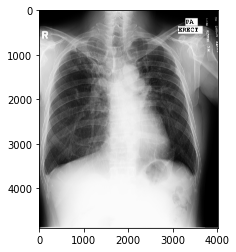

In [5]:
plt.imshow(img)

In [6]:
import cv2

In [7]:
cv2.imread(sample_image).shape

(4892, 4020, 3)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Train:Test ratio = 80:20

In [9]:
image_generator = ImageDataGenerator(rescale=1/1, validation_split=0.2)

In [10]:
seed = 1

#### Training Data (80%)

In [11]:
train_data_generator = image_generator.flow_from_directory(
    directory=image_dir,
    shuffle=True,
    subset='training',
    target_size=(100, 100),
    batch_size=20,
    class_mode='binary',
    seed=seed
)

Found 111 images belonging to 2 classes.


#### Validation DAta(20%)

In [12]:
validation_data_generator = image_generator.flow_from_directory(
    directory=image_dir,
    shuffle=True,
    subset='validation',
    target_size=(100, 100),
    batch_size=20,
    class_mode='binary',
    seed=seed
)

Found 27 images belonging to 2 classes.


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# Defining a Binary Neural Network Classifier

In [14]:
model = Sequential([
    Conv2D(16, (3,3), activation=MaxPool2D(2,2)),
    Conv2D(32, (3,3), activation=MaxPool2D(2,2)),
    Conv2D(64, (3,3), activation=MaxPool2D(2,2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

2022-05-30 16:33:14.152158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=0.001),
    metrics=['accuracy']
)

In [16]:
from tensorflow.keras.callbacks import Callback

#### In case the accuracy is achieved sooner, we would want to stop training

In [17]:
class TerminateOnBaseline(Callback):
    """Callback that terminates training when either acc or val_acc reaches a specified baseline
    """
    def __init__(self, monitor='accuracy', baseline=0.9):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = baseline

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get(self.monitor)
        if acc is not None:
            if acc >= self.baseline:
                print('Epoch %d: Reached baseline, terminating training' % (epoch))
                self.model.stop_training = True

In [18]:
callbacks = [TerminateOnBaseline(monitor='accuracy', baseline=0.98)]

### Training the model

In [19]:
model.fit(
    train_data_generator,
    steps_per_epoch=5,
    epochs=50,
    validation_data=validation_data_generator,
    callbacks=callbacks
)

Epoch 1/50
5/5 [==============================] - 36s 7s/step - loss: 1193.7007 - accuracy: 0.4615 - val_loss: 1220.0369 - val_accuracy: 0.4074
Epoch 2/50
5/5 [==============================] - 30s 6s/step - loss: 334.8014 - accuracy: 0.5100 - val_loss: 7.1209 - val_accuracy: 0.6667
Epoch 3/50
5/5 [==============================] - 28s 6s/step - loss: 24.5433 - accuracy: 0.5055 - val_loss: 15.9119 - val_accuracy: 0.4815
Epoch 4/50
5/5 [==============================] - 28s 6s/step - loss: 10.5424 - accuracy: 0.5275 - val_loss: 12.8773 - val_accuracy: 0.5926
Epoch 5/50
5/5 [==============================] - 28s 6s/step - loss: 3.4609 - accuracy: 0.7143 - val_loss: 8.3131 - val_accuracy: 0.5926
Epoch 6/50
5/5 [==============================] - 29s 6s/step - loss: 4.9197 - accuracy: 0.6484 - val_loss: 2.0397 - val_accuracy: 0.7407
Epoch 7/50
5/5 [==============================] - 28s 6s/step - loss: 3.3438 - accuracy: 0.6154 - val_loss: 9.0987 - val_accuracy: 0.5926
Epoch 8/50
5/5 [======

# Plotting the confusion matrix

In [20]:
import numpy as np

In [21]:
predictions = np.array([])
actual = np.array([])

for i in range(2):
  imgs, labels = list(validation_data_generator[i])
  predictions = np.concatenate([predictions, (np.concatenate(model.predict(imgs)) >= 0.5).astype('int32')])
  actual = np.concatenate([actual, labels])

1/1 [==============================] - 0s 18ms/step


In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [23]:
cm = confusion_matrix(actual, predictions)


In [24]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

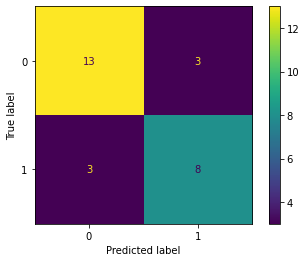

In [25]:
disp.plot()

# Prediction on sample images

In [73]:
def predict(image_path):
    img = image.load_img(image_path, target_size=(100, 100, 3))
    plt.imshow(img)
    img_data = image.img_to_array(img)
    prediction = model.predict(np.expand_dims(img_data, axis=0))
    predicted_label = "TB" if prediction >= 0.5 else 'No TB'
    plt.xlabel(
        f"Classified as: {predicted_label}", 
        color='red' if prediction >= 0.5 else 'green',
        fontsize=16,
    )

### Sample image with TB

1/1 [==============================] - 0s 17ms/step


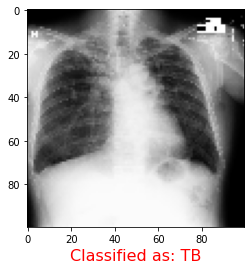

In [74]:
predict(sample_image)

### Sample image with No TB

1/1 [==============================] - 0s 16ms/step


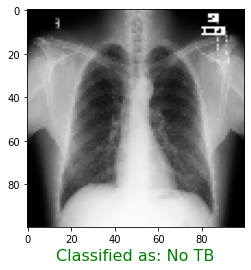

In [75]:
sample_image_no_tb = f'{image_dir}/0/MCUCXR_0103_0.png'
predict(sample_image_no_tb)